# 第十八、十九、二十次课-评分作业
**此次作业<span style="color:red;">成绩计入总评</span>，总分11分，高于10分的部分视为附加题成绩**

**请将作业命名为<span style="color:red;">HW18-评分作业+姓名+学号.ipynb</span>, 并于<span style="color:red;">6月10日23:59前</span>提交**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from matplotlib import pyplot as plt
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
torch.manual_seed(0)
np.random.seed(0)

### 读取数据并划分数据集（勿更改代码）

In [2]:

def findFiles(path): 
    return glob.glob(path)
tags = []
X = []
y = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

for filename in findFiles('data/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    if language not in tags:
        tags.append(language)
    lines = readLines(filename)
    for line in lines:
        X.append(line)
        y.append(language)

n_tags = len(tags)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =10, stratify = y)

In [4]:
X_train[:5], y_train[:5]

(['highly', 'hardware', 'resist', 'having', 'squeeze'],
 ['RB', 'NN', 'VB', 'VBG', 'NN'])

In [7]:
print(n_tags)
print(tags)

14
['CD', 'IN', 'JJ', 'NN', 'NNP', 'NNPS', 'NNS', 'RB', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


## 前言：本次作业使用的数据集用来完成词性标注任务，提前观察数据集的特点，有利于完成后续的任务

# 一、隐马尔可夫模型（2分）

### 1.1 准备数据（0.5分）

In [6]:
from hmmlearn import hmm
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [21]:
# 提取特征
def extract_features(data):
    # TODO: 0.5分

X_train_features, X_train_lengths = extract_features(X_train)
X_test_features, X_test_lengths = extract_features(X_test)

### 1.2 使用HMM模型进行训练、预测（1分）

In [22]:
# 训练HMM模型
hmm_model = hmm.MultinomialHMM(n_components=n_tags, n_iter=100)
hmm_model.fit(X_train_features, X_train_lengths)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=14, n_iter=100,
               n_trials=array([66, 57, 14, ..., 39,  1, 71]),
               random_state=RandomState(MT19937) at 0x1076F5F40)

In [23]:
# HMM预测
def hmm_predict(model, X, lengths):
    # TODO: 1分
    
y_train_pred = hmm_predict(hmm_model, X_train_features, X_train_lengths)
y_test_pred = hmm_predict(hmm_model, X_test_features, X_test_lengths)

### 1.3 模型评估（0.5分）

In [24]:
# 评估函数
def evaluate(y_true, y_pred):
    # TODO: 0.5分

# HMM结果
print("HMM结果")
print("train set accuracy:", round(evaluate(y_train_encoded, y_train_pred), 4))
print("test set accuracy:", round(evaluate(y_test_encoded, y_test_pred), 4))

HMM结果
train set accuracy: 0.0803
test set accuracy: 0.0813


## 二、RNN模型的应用（3分）

### 2.1 数据准备和预处理（0.5分）

### 字符的编码

本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

In [5]:
# 统计字符
s = set()
for path in findFiles('data/*.txt'):
    f = open(path,"r")
    for word in f.readlines():
        for char in word:
            s.add(char)
    f.close()
all_letters = ""
for c in s:
    all_letters+=str(c)

n_letters = len(all_letters)
n_letters, all_letters

(73,
 "4h:.vzwmEtINMP7-fx2CbDXc6\\@JGplH5\nTy&RqWu'0sdZeOYAkQFg3aonBU9,K%8S1rLVj/i")

In [6]:
#function to create name representation

def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [8]:
#function to create lang representation

def nat_rep(lang):
    return torch.tensor([tags.index(lang)], dtype = torch.long)

In [9]:
#create a dataloader

def dataloader(batch_size, X_, y_):
    to_ret = []
    # TODO: 0.5分
    for i in range(0, len(X_), batch_size):
        names = X_[i: i + batch_size]
        langs = y_[i: i+ batch_size]

        X_batch = [name_rep(name) for name in names]
        y_batch = [nat_rep(lang) for lang in langs]

        to_ret.append((X_batch, y_batch))
    return to_ret

### 2.2 RNN网络的搭建（1分）

In [10]:
class RNN_net(nn.Module):
    # TODO: 1分
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat([input, hidden], dim=1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros((1, self.hidden_size))

### 2.3 模型的训练（1分）

In [17]:
# function to train the data

def train_step(net, opt, criterion, batch_size):

    # TODO: 0.5分      
    total_loss = 0
    # net.to(device)
    data = dataloader(batch_size, X_train, y_train)
    random_index = random.randint(0, len(data)-1)
    X_batch, y_batch = data[random_index]

    for X, y in zip(X_batch, y_batch):
        
        hidden = net.initHidden()
        opt.zero_grad()

        for i in range(len(X)):
            output, hidden = net(X[i], hidden)
        loss = criterion(output, y)

        loss.backward()
        opt.step()

        total_loss += loss.item()

    return total_loss/batch_size

In [18]:
def train(net, lr = 0.01, steps = 100, batch_size = 10, momentum = 0.9, freq = 5):


    # TODO: 0.5分
    loss_arr = [0 for _ in range(steps)]
    opt = optim.Adam(net.parameters(), lr=lr, weight_decay=momentum)
    criterion = nn.CrossEntropyLoss()
    #iterate through all the batches
    for i in range(steps):
        loss_arr[i] = train_step(net, opt, criterion, batch_size)
        if (i+1)%freq==0: 
            print("Iteration number:", i + 1,'Loss:', round(loss_arr[i],4))

    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    print("\n\n")

Iteration number: 5 Loss: 2.5612
Iteration number: 10 Loss: 2.5414
Iteration number: 15 Loss: 0.6056
Iteration number: 20 Loss: 2.5504
Iteration number: 25 Loss: 2.5451
Iteration number: 30 Loss: 2.5448
Iteration number: 35 Loss: 2.5411
Iteration number: 40 Loss: 2.5449
Iteration number: 45 Loss: 2.5414
Iteration number: 50 Loss: 2.543
Iteration number: 55 Loss: 2.556
Iteration number: 60 Loss: 2.548
Iteration number: 65 Loss: 2.5463
Iteration number: 70 Loss: 2.5431
Iteration number: 75 Loss: 2.5487
Iteration number: 80 Loss: 2.5462
Iteration number: 85 Loss: 2.5395
Iteration number: 90 Loss: 2.5486
Iteration number: 95 Loss: 2.5426
Iteration number: 100 Loss: 2.5463


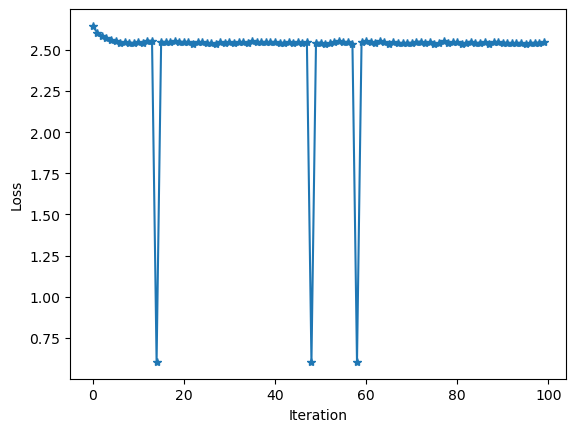

In [19]:
# RNN训练
n_hidden = 128
rnn_net = RNN_net(n_letters, n_hidden, n_tags)
train(rnn_net, lr = 0.0005, steps = 100, batch_size = 256)

### 2.4 模型的评估（0.5分）

In [24]:
def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.initHidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [25]:
#create a function to evaluate model

def eval_test(net):
     correct = 0
     for i in range(len(X_test)):
        name,lang = X_test[i],y_test[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_test)

     return accuracy

In [26]:
#create a function to evaluate model

def eval_train(net):
     # TODO: 0.5分
     correct = 0
     for i in range(len(X_train)):
          name, lang = X_train[i], y_train[i]
          name_ohe = name_rep(name)
          lang_rep = nat_rep(lang)
          output = infer(net, name)
          val, indices = output.topk(1)

          if indices == lang_rep:
               correct += 1

     accuracy = correct / len(X_train)

     return accuracy

In [27]:
print("rnn结果")
print("train set accuracy:"+str(round(eval_train(rnn_net),4)))
print("test set accuracy:"+str(round(eval_test(rnn_net),4)))

rnn结果
train set accuracy:0.3228
test set accuracy:0.3252


## 三、预训练模型的使用（3分）

### 3.1 数据准备和预处理，模型的导入（0.5分）

In [25]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# 初始化BERT模型和tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

### 3.2 使用BERT进行特征提取（1分）

In [26]:
# 提取BERT特征
def extract_bert_features(data):
    features = []
    # TODO: 1分
    bert_model.eval()

    with torch.inference_mode():
        for word in data:
            encoded_input = tokenizer(word, return_tensors='pt')
            output = bert_model(**encoded_input)
            cls_embedding = output.last_hidden_state[:, 0, :].detach().numpy() # shape: (1, 768)

            features.append(cls_embedding)
    
    return np.concatenate(features, axis=0)


# 提取训练集和测试集的特征
X_train_features = extract_bert_features(X_train)
X_test_features = extract_bert_features(X_test)

In [ ]:
# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

### 3.3 使用一个分类器对提取好的特征进行分类（1分）

In [28]:
# TODO: 1分
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_features, y_train_encoded)

LogisticRegression(max_iter=1000)

In [29]:
# 预测
y_train_pred = clf.predict(X_train_features)
y_test_pred = clf.predict(X_test_features)

### 3.4 评估结果（0.5分）

In [30]:
# 评估函数
def evaluate(y_true, y_pred):
    # TODO: 0.5分
    return accuracy_score(y_true, y_pred)

# BERT结果
print("BERT结果")
print("train set accuracy:", round(evaluate(y_train_encoded, y_train_pred), 4))
print("test set accuracy:", round(evaluate(y_test_encoded, y_test_pred), 4))

BERT结果
train set accuracy: 0.9069
test set accuracy: 0.7909


## 四、三种模型的总结与分析（1分）

请简述这次作业使用的数据集在三种模型下的表现产生显著差异的原因，并且给出能够提高HMM表现的数据加强方式。

HMM假设观测之间存在马尔可夫性质（无记忆性质），即下一个状态只依赖于当前状态。

基础RNN模型常常面临梯度消失或梯度爆炸的问题，这限制了它在长序列中学习长距离依赖的能力。

相比HMM和RNN，Bert能更好地理解文本的上下文，尤其是在捕捉长距离依赖关系方面表现卓越。

数据加强方式：增加数据多样性

## 附加题：期末笔试题目的参考

### 附加题 马尔可夫模型的原理理解（1分）

(1) 阅读以下题目，补全solve函数，并且将结果提交到codeforces平台上，将代码运行结果截图（包含用户名、AC的结果、运行时间等信息）（0.5分）

提交的网址：https://codeforces.com/problemset/problem/1025/G

运行结果截图

![](./3.png)

![](./1.png)

In [ ]:
def solve(n,lis):
    # TODO: 0.5分

n=int(input())
lis=input().split()
solve(n,lis)

(2) 对以上代码的正确性给出证明（0.5分）